In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
from scipy import optimize as op
import uncertainties as unc
from time import time

In [5]:
import matplotlib
matplotlib.use("pgf")
matplotlib.rcParams.update({
    "pgf.texsystem": "pdflatex",
    'font.family': 'serif',
#     'font.size' : 14.4,
    'font.size' : 17.28,
    'text.usetex': True,
    'pgf.rcfonts': False,
})

In [3]:
#load
big_folder = 'sim'
def load(D = 1, N = 1024, suffix = '_para',df_suffix=''):
    folder = big_folder + ('/D%d_N%d' %(D,N)) + suffix
    if not os.path.exists(folder):
        raise ValueError(folder+ ' does not exists')
    return pd.read_csv(folder+'/results'+df_suffix+'.csv')

def smoothen(a,n):
    return np.array([np.mean(a[i:i+n]) for i in range(len(a) - n)])

def r_chi2(func, args, x, y, sigy = []):
    ddof = len(x) - len(args)
    chi2 = 0
    for i in range(len(x)):
        if len(sigy) == 0:
            chi2 += (y[i] - func(x[i],*args))**2
        else:
            chi2 += ((y[i] - func(x[i],*args))/sigy[i])**2
    return chi2/ddof

@np.vectorize
def beta_exponent(k,beta,k_c,A):
    if k < k_c:
        return 0.
    return 1.*A*(1/k_c - 1/k)**beta

@np.vectorize
def delta_exponent(h,delta,A):
    return A*h**(1./delta)

@np.vectorize
def gamma_exponent(k,gamma,k_c,A):
    return A*np.abs(1/k_c - 1/k)**(-gamma)

@np.vectorize
def alpha_exponent(k,alpha,k_c,A):
    return A*np.abs(1/k_c - 1/k)**(-alpha)

@np.vectorize
def alpha_exponent2(k,alpha_1,alpha_2,k_c,A):
    if k < k_c:
        return A*np.abs(1/k_c - 1/k)**(-alpha_1)
    else:
        return A*np.abs(1/k_c - 1/k)**(-alpha_2)

@np.vectorize
def alpha_exponent3(k,alpha_1,alpha_2,k_c,A_1,A_2):
    if k < k_c:
        return A_1*np.abs(1/k_c - 1/k)**(-alpha_1)
    else:
        return A_2*np.abs(1/k_c - 1/k)**(-alpha_2)
    
    
def submit(ofile,D,N,exp_name,exponent,note=''):
    if os.path.exists(ofile):
        df = pd.read_csv(ofile)
    else:
        df = pd.DataFrame(data=[],columns=['D','N','exp_name','exp_value','exp_std','notes'])
    df.loc[len(df)] = [D,N,exp_name,exponent.n,exponent.s,note]
    df.to_csv(ofile,index=False)

<IPython.core.display.Javascript object>


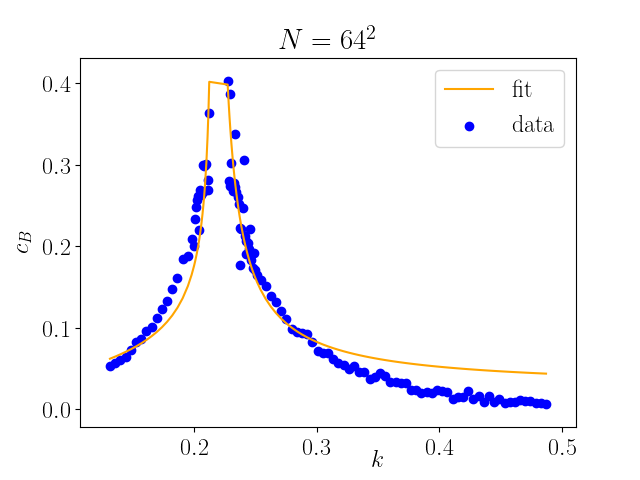

[0.49589321 0.93717663 0.21563415 0.10574744]


In [125]:
## trying estimate alpha
%matplotlib notebook
D = 2
N = 64
suffix = ''

n = 3
k_c_0 = 0.221
delta_k = 0.005

k_min, k_max = 0., 0.5
k_u, k_l = k_c_0 - delta_k, k_c_0 + delta_k


df = load(D=D,N=N,suffix=suffix)
fig,ax = plt.subplots()

ks = np.array([k for k in df['k'] if k >= k_min and k < k_u])
ts = smoothen(1/ks, n)
ks = 1/ts[:-1]
aas = smoothen(np.array([a for i,a in enumerate(df['a']) if df['k'][i] >= k_min and df['k'][i] < k_u]), n)
c_Bs = -np.diff(aas,1)/np.diff(ts,1)

ks_2 = np.array([k for k in df['k'] if k >= k_l and k < k_max])
ts = smoothen(1/ks_2, n)
ks_2 = 1/ts[:-1]
aas = smoothen(np.array([a for i,a in enumerate(df['a']) if df['k'][i] >= k_l and df['k'][i] < k_max]), n)
c_Bs_2 = -np.diff(aas,1)/np.diff(ts,1)

ks = np.concatenate([ks,ks_2])
c_Bs = np.concatenate([c_Bs,c_Bs_2])
# print(len(ks))

popt,pcov = op.curve_fit(alpha_exponent2, ks, c_Bs, p0=[0.1,0.1,k_c_0,1.,1.])
print(popt)

plt.scatter(ks,c_Bs,label='data',color='blue')
plt.plot(ks,alpha_exponent2(ks,*popt),label='fit',color='orange')

plt.xlabel('$k$')
plt.ylabel('$c_B$')
plt.title('$N = %d^%d$' %(N,D))
plt.legend()

ax.xaxis.set_label_coords(0.6,-0.06)
# fig.savefig('report/img/D2_N64_gamma_fail.pgf')

<IPython.core.display.Javascript object>


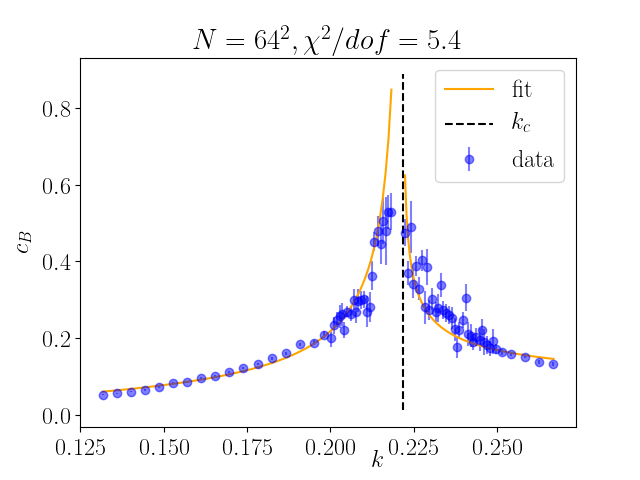

[0.69711922 0.36602769 0.22173681 0.13238623 0.13216496]
0.697+/-0.009 0.366+/-0.021
0.22174+/-0.00020


In [12]:
## trying estimate alpha
%matplotlib notebook
D = 2
N = 64
suffix = ''

n = 3
k_c_0 = 0.221
delta_k = 0.0
two_A = True
k_min, k_max = 0.0, 0.28
k_u, k_l = k_c_0 - delta_k, k_c_0 + delta_k


df = load(D=D,N=N,suffix=suffix)
fig,ax = plt.subplots()

ks = np.array([k for k in df['k'] if k >= k_min and k < k_u])
ts = smoothen(1/ks, n)
ks = 1/ts[:-1]
as_n = np.array([a for i,a in enumerate(df['a']) if df['k'][i] >= k_min and df['k'][i] < k_u])
as_s = np.array([a for i,a in enumerate(df['a_std']) if df['k'][i] >= k_min and df['k'][i] < k_u])
aas = smoothen(np.array([unc.ufloat(as_n[i],as_s[i]) for i in range(len(as_n))]), n)
c_Bs = -np.diff(aas,1)/np.diff(ts,1)
ks_fine = np.linspace(ks[0],ks[-1],100)
# print(len(ks))

ks_2 = np.array([k for k in df['k'] if k >= k_l and k < k_max])
ts = smoothen(1/ks_2, n)
ks_2 = 1/ts[:-1]
as_n = np.array([a for i,a in enumerate(df['a']) if df['k'][i] >= k_l and df['k'][i] < k_max])
as_s = np.array([a for i,a in enumerate(df['a_std']) if df['k'][i] >= k_l and df['k'][i] < k_max])
aas = smoothen(np.array([unc.ufloat(as_n[i],as_s[i]) for i in range(len(as_n))]), n)
c_Bs_2 = -np.diff(aas,1)/np.diff(ts,1)
ks_fine_2 = np.linspace(ks_2[0],ks_2[-1],100)
# print(len(ks))

ks = np.concatenate([ks,ks_2])
c_Bs = np.concatenate([c_Bs,c_Bs_2])
# ks_fine = np.linspace(ks[0],ks[-1],100)
# print(len(ks))

if two_A:
    popt,pcov = op.curve_fit(alpha_exponent3, ks, [c_B.n for c_B in c_Bs],
                             sigma=[c_B.s for c_B in c_Bs], absolute_sigma=True,
                             p0=[1,1,k_c_0,0.1,0.1])
    alpha_1,alpha_2,k_c,A_1,A_2 = unc.correlated_values(popt,pcov)
    func = alpha_exponent3
else:
    popt,pcov = op.curve_fit(alpha_exponent2, ks, [c_B.n for c_B in c_Bs],
                             sigma=[c_B.s for c_B in c_Bs], absolute_sigma=True,
                             p0=[0.1,0.1,k_c_0,0.1])
    alpha_1,alpha_2,k_c,A = unc.correlated_values(popt,pcov)
    func = alpha_exponent2
print(popt)

plt.errorbar(ks,[c_B.n for c_B in c_Bs], yerr=[c_B.s for c_B in c_Bs],fmt='o',
             label='data',color='blue',alpha=0.5)
plt.plot(ks_fine,func(ks_fine,*popt),label='fit',color='orange')
plt.plot(ks_fine_2,func(ks_fine_2,*popt),color='orange')
plt.plot([k_c.n,k_c.n],ax.get_ylim(),color='black',linestyle='dashed',label='$k_c$')


plt.xlabel('$k$')
plt.ylabel('$c_B$')
plt.title(r'$N = %d^%d, \chi^2/dof = %.1f$' %(N,D,r_chi2(func, popt, ks,
                                                    [c_B.n for c_B in c_Bs], [c_B.s for c_B in c_Bs])))
plt.legend()

ax.xaxis.set_label_coords(0.6,-0.06)
# fig.savefig('report/img/D2_N64_alpha.pgf')

print(alpha_1,alpha_2)
print(k_c)

<IPython.core.display.Javascript object>


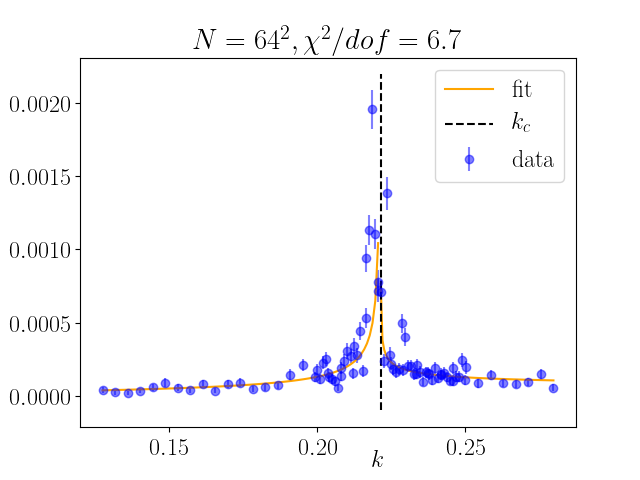

[6.14330175e-01 2.95955976e-01 2.21365997e-01 8.49130815e-05
 1.06391967e-04]
0.614+/-0.022 0.30+/-0.04
0.22137+/-0.00005


In [14]:
## trying estimate alpha
%matplotlib notebook
D = 2
N = 64
suffix = ''

n = 3
k_c_0 = 0.221
delta_k = 0.0
two_A = True
k_min, k_max = 0.0, 0.28
k_u, k_l = k_c_0 - delta_k, k_c_0 + delta_k


df = load(D=D,N=N,suffix=suffix)
fig,ax = plt.subplots()

ks = np.array([k for k in df['k'] if k >= k_min and k < k_u])
sig_as = np.array([sa for i,sa in enumerate(df['a_std']) if df['k'][i] >= k_min and df['k'][i] < k_u])
c_Bs = sig_as**2*N**D*ks**2
ks_fine = np.linspace(ks[0],ks[-1],100)
# print(len(ks))

ks_2 = np.array([k for k in df['k'] if k >= k_l and k < k_max])
sig_as = np.array([sa for i,sa in enumerate(df['a_std']) if df['k'][i] >= k_l and df['k'][i] < k_max])
c_Bs_2 = sig_as**2*N**D*ks_2**2
ks_fine_2 = np.linspace(ks_2[0],ks_2[-1],100)
# print(len(ks))

ks = np.concatenate([ks,ks_2])
c_Bs = np.concatenate([c_Bs,c_Bs_2])
sig_cBs = c_Bs**0.5*0.003
arr = []
for i in range(len(c_Bs)):
    arr.append(unc.ufloat(c_Bs[i],sig_cBs[i]))
c_Bs = np.array(arr)
# ks_fine = np.linspace(ks[0],ks[-1],100)
# print(len(ks))

if two_A:
    popt,pcov = op.curve_fit(alpha_exponent3, ks, [c_B.n for c_B in c_Bs],
                             sigma=[c_B.s for c_B in c_Bs], absolute_sigma=True,
                             p0=[1,1,k_c_0,0.1,0.1])
    alpha_1,alpha_2,k_c,A_1,A_2 = unc.correlated_values(popt,pcov)
    func = alpha_exponent3
else:
    popt,pcov = op.curve_fit(alpha_exponent2, ks, [c_B.n for c_B in c_Bs],
                             sigma=[c_B.s for c_B in c_Bs], absolute_sigma=True,
                             p0=[0.1,0.1,k_c_0,0.1])
    alpha_1,alpha_2,k_c,A = unc.correlated_values(popt,pcov)
    func = alpha_exponent2
print(popt)

plt.errorbar(ks,[c_B.n for c_B in c_Bs], yerr=[c_B.s for c_B in c_Bs],fmt='o',
             label='data',color='blue',alpha=0.5)
plt.plot(ks_fine,func(ks_fine,*popt),label='fit',color='orange')
plt.plot(ks_fine_2,func(ks_fine_2,*popt),color='orange')
plt.plot([k_c.n,k_c.n],ax.get_ylim(),color='black',linestyle='dashed',label='$k_c$')


plt.xlabel('$k$')
plt.ylabel('$c_B$')
plt.title(r'$N = %d^%d, \chi^2/dof = %.1f$' %(N,D,r_chi2(func, popt, ks,
                                                    [c_B.n for c_B in c_Bs], [c_B.s for c_B in c_Bs])))
plt.legend()

ax.xaxis.set_label_coords(0.6,-0.06)
# fig.savefig('report/img/D2_N64_alpha.pgf')

print(alpha_1,alpha_2)
print(k_c)

In [28]:
submit('critical_exponents.csv',D,N,'alpha_1',alpha_1)
submit('critical_exponents.csv',D,N,'alpha_2',alpha_2)
submit('critical_exponents.csv',D,N,'k_c',k_c,note='from alpha')

<IPython.core.display.Javascript object>


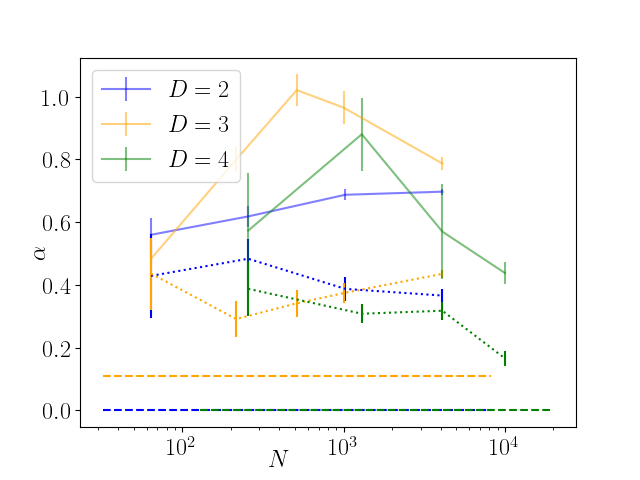

2 8 [0.55973809 0.4287967  0.25688947 0.16481048 0.04657305] 2.123535248638004
2 16 [0.61824507 0.48344449 0.22870288 0.13678177 0.08333256] 2.583639636932647
2 32 [0.68727301 0.38725811 0.22430965 0.13536306 0.11380567] 3.0311797354640975
2 64 [0.69711922 0.36602769 0.22173681 0.13238623 0.13216496] 5.358062877289455
3 4 [0.48349355 0.43587649 0.14568295 0.14071467 0.05110677] 2.036515838529234
3 6 [0.79974096 0.29108185 0.12582994 0.11654499 0.09499949] 2.2585811476903355
3 8 [1.02085035 0.34142262 0.11717304 0.08663097 0.14209855] 1.9070214448051857
3 10 [0.96499915 0.37387032 0.11437809 0.06914928 0.16124107] 1.7504858995413708
3 16 [0.78691093 0.43532457 0.11214394 0.05277028 0.17814078] 2.614935339546216
4 4 [0.57307953 0.38754323 0.08220942 0.10524013 0.12398928] 1.121927712126675
4 6 [0.88013538 0.30814595 0.0777591  0.05309944 0.14769227] 2.3684785851388495
4 8 [0.56975319 0.3176869  0.07488619 0.02611874 0.18073341] 1.6580554153393394
4 10 [0.43797823 0.16585124 0.07432891 0.

In [85]:
## mass estimation of alpha
alpha_ths = [0,0,0.,0.11,0.]
Ds = [2,3,4]
colors = ['blue','orange','green']
Ns = [[],
      [],
      [8,16,32,64],
      [4,6,8,10,16],
      [4,6,8,10]]
suffix = ''
k_min = 0
k_maxs = [[],
          [],
          [0.4,0.35,0.3,0.28],
          [0.25,0.19,0.17,0.16,0.155],
          [0.13,0.11,0.095,0.09]]
k_c_0s = [[],
          [],
          [0.254,0.229,0.224,0.221],
          [0.145,0.125,0.117,0.115,0.113],
          [0.083,0.078,0.076,0.075]]
delta_k = 0.

fig,ax = plt.subplots()
for j,D in enumerate(Ds):
    alpha_1s = []
    alpha_2s = []
    k_cs = []
    for i,N in enumerate(Ns[D]):
        try:
            df = load(D,N,suffix)
        except ValueError:
            continue

        k_max = k_maxs[D][i]
        k_c_0 = k_c_0s[D][i]
        k_u, k_l = k_c_0 - delta_k, k_c_0 + delta_k
        
        ks = np.array([k for k in df['k'] if k >= k_min and k < k_u])
        ts = smoothen(1/ks, n)
        ks = 1/ts[:-1]
        as_n = np.array([a for i,a in enumerate(df['a']) if df['k'][i] >= k_min and df['k'][i] < k_u])
        as_s = np.array([a for i,a in enumerate(df['a_std']) if df['k'][i] >= k_min and df['k'][i] < k_u])
        aas = smoothen(np.array([unc.ufloat(as_n[i],as_s[i]) for i in range(len(as_n))]), n)
        c_Bs = -np.diff(aas,1)/np.diff(ts,1)

        ks_2 = np.array([k for k in df['k'] if k >= k_l and k < k_max])
        ts = smoothen(1/ks_2, n)
        ks_2 = 1/ts[:-1]
        as_n = np.array([a for i,a in enumerate(df['a']) if df['k'][i] >= k_l and df['k'][i] < k_max])
        as_s = np.array([a for i,a in enumerate(df['a_std']) if df['k'][i] >= k_l and df['k'][i] < k_max])
        aas = smoothen(np.array([unc.ufloat(as_n[i],as_s[i]) for i in range(len(as_n))]), n)
        c_Bs_2 = -np.diff(aas,1)/np.diff(ts,1)

        ks = np.concatenate([ks,ks_2])
        c_Bs = np.concatenate([c_Bs,c_Bs_2])
        
        popt,pcov = op.curve_fit(alpha_exponent3, ks, [c_B.n for c_B in c_Bs],
                             sigma=[c_B.s for c_B in c_Bs], absolute_sigma=True,
                             p0=[1,1,k_c_0,0.1,0.1])
        alpha_1,alpha_2,k_c,A_1,A_2 = unc.correlated_values(popt,pcov)

        print(D,N,popt,r_chi2(alpha_exponent3,popt,ks,[c_B.n for c_B in c_Bs],sigy=[c_B.s for c_B in c_Bs]))
        alpha_1s.append(alpha_1)
        alpha_2s.append(alpha_2)
        k_cs.append(k_c)
        
#         submit('critical_exponents.csv',D,N,'alpha_1',alpha_1)
#         submit('critical_exponents.csv',D,N,'alpha_2',alpha_2)
#         submit('critical_exponents.csv',D,N,'k_c',k_c,note='from alpha')

    plt.semilogx([0.5*Ns[D][0]**D,2*Ns[D][-1]**D], [alpha_ths[D],alpha_ths[D]],
                 linestyle='dashed',color=colors[j])
    plt.errorbar(np.array(Ns[D])**D,[a.n for a in alpha_1s],yerr=[a.s for a in alpha_1s],
                 label='$D=%d$' %D,color=colors[j],alpha=0.5)
    plt.errorbar(np.array(Ns[D])**D,[a.n for a in alpha_2s],yerr=[a.s for a in alpha_2s],
                 linestyle='dotted',color=colors[j])
    
plt.legend(loc='upper left')
plt.xlabel('$N$')
plt.ylabel(r'$\alpha$')

ax.xaxis.set_label_coords(0.4,-0.06)
ax.yaxis.set_label_coords(-0.06,0.47)

# fig.savefig('report/img/alphas.pgf')

<IPython.core.display.Javascript object>


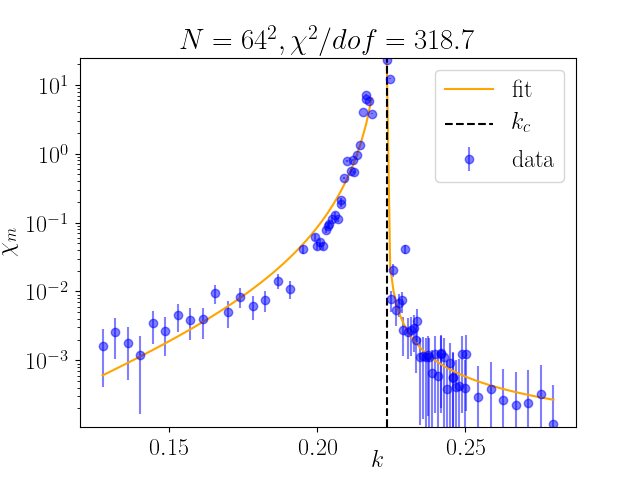

[2.66407198e+00 1.21479478e+00 2.23465425e-01 1.53572771e-02
 2.35945927e-04]
2.664+/-0.012 1.21+/-0.08
0.2234654+/-0.0000019


In [6]:
## trying estimate gamma as var(m)
%matplotlib notebook
D = 2
N = 64
suffix = ''

k_c_0 = 0.221
k_c = k_c_0
delta_k = 0.002
two_A = True

k_min, k_max = 0., 0.28
k_u, k_l = k_c - delta_k, k_c + delta_k


df = load(D=D,N=N,suffix=suffix)
fig,ax = plt.subplots()

ks = np.array([k for k in df['k'] if k >= k_min and k < k_u])
sig_ms = np.array([sm for i,sm in enumerate(df['m_std']) if df['k'][i] >= k_min and df['k'][i] < k_u])
chis = sig_ms**2*N**D*ks
ks_fine = np.linspace(ks[0],ks[-1],50)
# print(len(ks))

ks_2 = np.array([k for k in df['k'] if k >= k_l and k < k_max])
sig_ms = np.array([sm for i,sm in enumerate(df['m_std']) if df['k'][i] >= k_l and df['k'][i] < k_max])
chis_2 = sig_ms**2*N**D*ks_2
ks_fine_2 = np.linspace(ks_2[0],ks_2[-1],50)

ks = np.concatenate([ks, ks_2])
chis = np.concatenate([chis, chis_2])
sig_chis = chis**0.5*0.03

if two_A:
    popt,pcov = op.curve_fit(alpha_exponent3, ks, chis, p0=[1.2,1.,k_c_0,1.,1.],
                             sigma=sig_chis,absolute_sigma=True)
    func = alpha_exponent3
    gamma_1,gamma_2,k_c,A_1,A_2 = unc.correlated_values(popt,pcov)
else:
    popt,pcov = op.curve_fit(alpha_exponent2, ks, chis, p0=[1.,1.,k_c_0,1.])
    func = alpha_exponent2
    gamma_1,gamma_2,k_c,A = unc.correlated_values(popt,pcov)
print(popt)

plt.ylim(0.9*np.min(chis),1.1*np.max(chis))

plt.errorbar(ks,chis,yerr=sig_chis,fmt='o',label='data',color='blue',alpha=0.5)
plt.semilogy(ks_fine,func(ks_fine,*popt),label='fit',color='orange')
plt.semilogy(ks_fine_2,func(ks_fine_2,*popt),color='orange')
plt.plot([k_c.n,k_c.n],ax.get_ylim(),color='black',linestyle='dashed',label='$k_c$')



plt.xlabel('$k$')
plt.ylabel('$\chi_m$')
plt.title(r'$N = %d^%d, \chi^2/dof = %.1f$' %(N,D,r_chi2(func, popt, ks, chis,sigy=sig_chis)))
plt.legend()


ax.xaxis.set_label_coords(0.6,-0.06)
# fig.savefig('report/img/D2_N64_gamma.pgf')
print(gamma_1,gamma_2)
print(k_c)

<IPython.core.display.Javascript object>


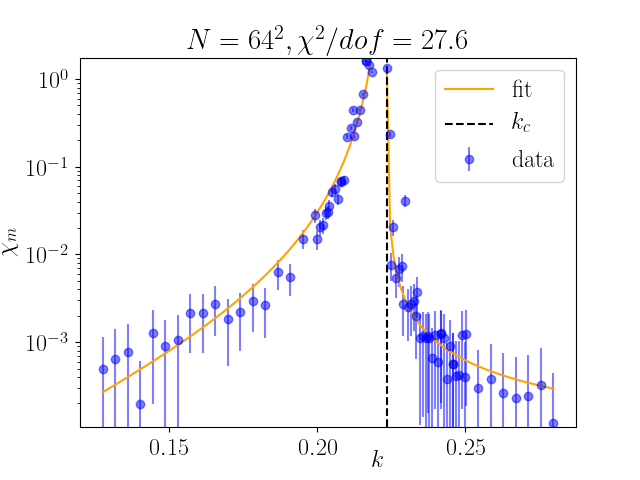

[2.54063144e+00 1.16727827e+00 2.23436006e-01 5.84850538e-03
 2.60777346e-04]
2.541+/-0.022 1.17+/-0.09
0.223436+/-0.000012


In [7]:
## trying estimate gamma as var(|m|)
%matplotlib notebook
D = 2
N = 64
suffix = ''
df_suffix = '_a'

k_c_0 = 0.221
k_c = k_c_0
delta_k = 0.002
two_A = True

k_min, k_max = 0., 0.28
k_u, k_l = k_c - delta_k, k_c + delta_k


df = load(D=D,N=N,suffix=suffix,df_suffix=df_suffix)
fig,ax = plt.subplots()

ks = np.array([k for k in df['k'] if k >= k_min and k < k_u])
sig_ms = np.array([sm for i,sm in enumerate(df['abs_m_std']) if df['k'][i] >= k_min and df['k'][i] < k_u])
chis = sig_ms**2*N**D*ks
ks_fine = np.linspace(ks[0],ks[-1],50)
# print(len(ks))

ks_2 = np.array([k for k in df['k'] if k >= k_l and k < k_max])
sig_ms = np.array([sm for i,sm in enumerate(df['abs_m_std']) if df['k'][i] >= k_l and df['k'][i] < k_max])
chis_2 = sig_ms**2*N**D*ks_2
ks_fine_2 = np.linspace(ks_2[0],ks_2[-1],50)

ks = np.concatenate([ks, ks_2])
chis = np.concatenate([chis, chis_2])
sig_chis = chis**0.5*0.03

if two_A:
    popt,pcov = op.curve_fit(alpha_exponent3, ks, chis, p0=[1.2,1.,k_c_0,1.,1.],
                             sigma=sig_chis,absolute_sigma=True)
    func = alpha_exponent3
    gamma_1,gamma_2,k_c,A_1,A_2 = unc.correlated_values(popt,pcov)
else:
    popt,pcov = op.curve_fit(alpha_exponent2, ks, chis, p0=[1.,1.,k_c_0,1.])
    func = alpha_exponent2
    gamma_1,gamma_2,k_c,A = unc.correlated_values(popt,pcov)
print(popt)

plt.ylim(0.9*np.min(chis),1.1*np.max(chis))

plt.errorbar(ks,chis,yerr=sig_chis,fmt='o',label='data',color='blue',alpha=0.5)
plt.semilogy(ks_fine,func(ks_fine,*popt),label='fit',color='orange')
plt.semilogy(ks_fine_2,func(ks_fine_2,*popt),color='orange')
plt.plot([k_c.n,k_c.n],ax.get_ylim(),color='black',linestyle='dashed',label='$k_c$')



plt.xlabel('$k$')
plt.ylabel('$\chi_m$')
plt.title(r'$N = %d^%d, \chi^2/dof = %.1f$' %(N,D,r_chi2(func, popt, ks, chis,sigy=sig_chis)))
plt.legend()


ax.xaxis.set_label_coords(0.6,-0.06)
# fig.savefig('report/img/D2_N64_gamma.pgf')
print(gamma_1,gamma_2)
print(k_c)

<IPython.core.display.Javascript object>


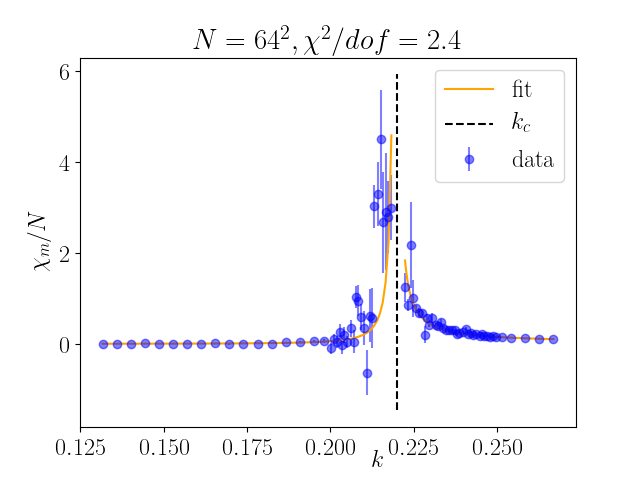

[1.72256693 1.02731445 0.22007472 0.01465598 0.0817921 ]
1.72+/-0.14 1.03+/-0.05
0.2201+/-0.0005


In [73]:
## trying estimate gamma as d|m|/dT
%matplotlib notebook
D = 2
N_index = 3
N = Ns[D][N_index]
suffix = ''
df_suffix = '_a'

n = 3
k_c_0 = k_c_0s[D][N_index]
delta_k = 0.00
two_A = True
k_min, k_max = 0.0, k_maxs[D][N_index]
k_u, k_l = k_c_0 - delta_k, k_c_0 + delta_k


df = load(D=D,N=N,suffix=suffix,df_suffix=df_suffix)
fig,ax = plt.subplots()

ks = np.array([k for k in df['k'] if k >= k_min and k < k_u])
ts = smoothen(1/ks, n)
ks = 1/ts[:-1]
as_n = np.array([a for i,a in enumerate(df['abs_m']) if df['k'][i] >= k_min and df['k'][i] < k_u])
as_s = np.array([a for i,a in enumerate(df['abs_m_std']) if df['k'][i] >= k_min and df['k'][i] < k_u])
aas = smoothen(np.array([unc.ufloat(as_n[i],as_s[i]) for i in range(len(as_n))]), n)
c_Bs = -np.diff(aas,1)/np.diff(ts,1)
ks_fine = np.linspace(ks[0],ks[-1],100)
# print(len(ks))

ks_2 = np.array([k for k in df['k'] if k >= k_l and k < k_max])
ts = smoothen(1/ks_2, n)
ks_2 = 1/ts[:-1]
as_n = np.array([a for i,a in enumerate(df['abs_m']) if df['k'][i] >= k_l and df['k'][i] < k_max])
as_s = np.array([a for i,a in enumerate(df['abs_m_std']) if df['k'][i] >= k_l and df['k'][i] < k_max])
aas = smoothen(np.array([unc.ufloat(as_n[i],as_s[i]) for i in range(len(as_n))]), n)
c_Bs_2 = -np.diff(aas,1)/np.diff(ts,1)
ks_fine_2 = np.linspace(ks_2[0],ks_2[-1],100)
# print(len(ks))

ks = np.concatenate([ks,ks_2])
c_Bs = np.concatenate([c_Bs,c_Bs_2])
# ks_fine = np.linspace(ks[0],ks[-1],100)
# print(len(ks))

if two_A:
    popt,pcov = op.curve_fit(alpha_exponent3, ks, [c_B.n for c_B in c_Bs],
                             sigma=[c_B.s for c_B in c_Bs], absolute_sigma=True,
                             p0=[1,1,k_c_0,0.1,0.1])
    alpha_1,alpha_2,k_c,A_1,A_2 = unc.correlated_values(popt,pcov)
    func = alpha_exponent3
else:
    popt,pcov = op.curve_fit(alpha_exponent2, ks, [c_B.n for c_B in c_Bs],
                             sigma=[c_B.s for c_B in c_Bs], absolute_sigma=True,
                             p0=[0.1,0.1,k_c_0,0.1])
    alpha_1,alpha_2,k_c,A = unc.correlated_values(popt,pcov)
    func = alpha_exponent2
print(popt)

plt.errorbar(ks,[c_B.n for c_B in c_Bs], yerr=[c_B.s for c_B in c_Bs],fmt='o',
             label='data',color='blue',alpha=0.5)
plt.plot(ks_fine,func(ks_fine,*popt),label='fit',color='orange')
plt.plot(ks_fine_2,func(ks_fine_2,*popt),color='orange')
plt.plot([k_c.n,k_c.n],ax.get_ylim(),color='black',linestyle='dashed',label='$k_c$')


plt.xlabel('$k$')
plt.ylabel('$\chi_m/N$')
plt.title(r'$N = %d^%d, \chi^2/dof = %.1f$' %(N,D,r_chi2(func, popt, ks,
                                                    [c_B.n for c_B in c_Bs], [c_B.s for c_B in c_Bs])))
plt.legend()

ax.xaxis.set_label_coords(0.6,-0.06)
# fig.savefig('report/img/D2_N64_gamma_d.pgf')

print(alpha_1,alpha_2)
print(k_c)

In [72]:
submit('critical_exponents.csv',D,N,'gamma_1',gamma_1)
submit('critical_exponents.csv',D,N,'gamma_2',gamma_2)
submit('critical_exponents.csv',D,N,'k_c',k_c,note='from gamma')

<IPython.core.display.Javascript object>


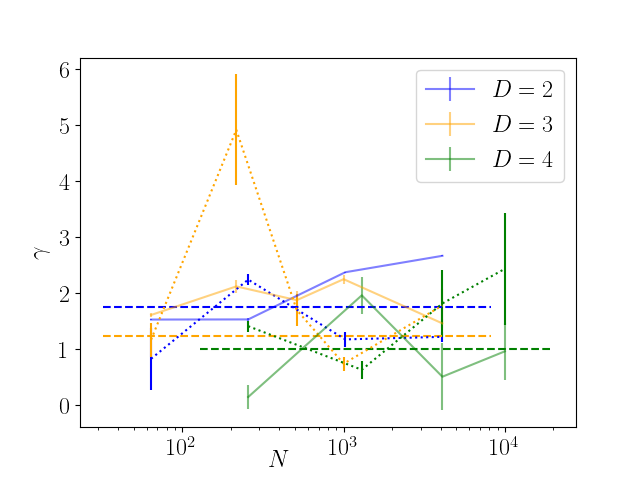

2 8 [1.52393022e+00 8.22776374e-01 2.58605653e-01 3.19650078e-02
 3.27816077e-05] 38.39704357420168
2 16 [1.52649853e+00 2.23834418e+00 2.30409221e-01 2.83399726e-02
 1.75165584e-04] 250.18461876308754
2 32 [2.37031237e+00 1.16927628e+00 2.26517234e-01 2.65762110e-02
 1.90955502e-04] 137.5224043165583
2 64 [2.66407213e+00 1.21484440e+00 2.23465424e-01 1.53572678e-02
 2.35913475e-04] 318.70942548951194
3 4 [1.60581615e+00 1.16427266e+00 1.47231496e-01 2.99642397e-02
 4.82031614e-05] 38.75195172204476
3 6 [2.11710906e+00 4.91753544e+00 1.26181779e-01 2.59329267e-02
 2.28610033e-06] 48.948283858008
3 8 [1.87058798e+00 1.69531163e+00 1.16624393e-01 9.06921499e-03
 3.01583292e-04] 17.8632958335404
3 10 [2.24625950e+00 7.34985007e-01 1.17341689e-01 1.25788047e-02
 2.68790198e-04] 19.20913666243543
3 16 [1.45516145e+00 1.77530777e+00 1.11192347e-01 4.69599758e-03
 5.73476506e-04] 2.7297933638621874
4 4 [1.38712082e-01 1.40533797e+00 7.70802492e-02 3.99597287e-03
 1.13706800e-03] 36.7121331363

In [86]:
## mass estimation of gamma as var(m)
gamma_ths = [0,0,1.75,1.237,1.]
Ds = [2,3,4]
colors = ['blue','orange','green']
Ns = [[],
      [],
      [8,16,32,64],
      [4,6,8,10,16],
      [4,6,8,10]]
suffix = ''
k_min = 0
k_maxs = [[],
          [],
          [0.4,0.35,0.3,0.28],
          [0.25,0.19,0.17,0.16,0.155],
          [0.13,0.11,0.095,0.09]]
k_c_0s = [[],
          [],
          [0.254,0.229,0.224,0.221],
          [0.145,0.125,0.117,0.115,0.113],
          [0.083,0.078,0.076,0.075]]
delta_k = 0.002

fig,ax = plt.subplots()
for j,D in enumerate(Ds):
    gamma_1s = []
    gamma_2s = []
    k_cs = []
    for i,N in enumerate(Ns[D]):
        try:
            df = load(D,N,suffix)
        except ValueError:
            continue

        k_max = k_maxs[D][i]
        k_c_0 = k_c_0s[D][i]
        k_u, k_l = k_c_0 - delta_k, k_c_0 + delta_k
        
        ks = np.array([k for k in df['k'] if k >= k_min and k < k_u])
        sig_ms = np.array([sm for i,sm in enumerate(df['m_std']) if df['k'][i] >= k_min and df['k'][i] < k_u])
        chis = sig_ms**2*N**D*ks
        
        ks_2 = np.array([k for k in df['k'] if k >= k_l and k < k_max])
        sig_ms = np.array([sm for i,sm in enumerate(df['m_std']) if df['k'][i] >= k_l and df['k'][i] < k_max])
        chis_2 = sig_ms**2*N**D*ks_2

        ks = np.concatenate([ks, ks_2])
        chis = np.concatenate([chis, chis_2])
        sig_chis = chis**0.5*0.03
        
        popt,pcov = op.curve_fit(alpha_exponent3, ks, chis, p0=[1.,1.,k_c_0,1.,1.],
                                 sigma=sig_chis,absolute_sigma=True)
        gamma_1,gamma_2,k_c,A_1,A_2 = unc.correlated_values(popt,pcov)

        print(D,N,popt,r_chi2(alpha_exponent3,popt,ks,chis,sigy=sig_chis))
        gamma_1s.append(gamma_1)
        gamma_2s.append(gamma_2)
        k_cs.append(k_c)
        
#         submit('critical_exponents.csv',D,N,'gamma_1',gamma_1)
#         submit('critical_exponents.csv',D,N,'gamma_2',gamma_2)
#         submit('critical_exponents.csv',D,N,'k_c',k_c,note='from gamma')

    plt.semilogx([0.5*Ns[D][0]**D,2*Ns[D][-1]**D], [gamma_ths[D],gamma_ths[D]],
                 linestyle='dashed',color=colors[j])
    plt.errorbar(np.array(Ns[D])**D,[a.n for a in gamma_1s],yerr=[a.s for a in gamma_1s],
                 label='$D=%d$' %D,color=colors[j],alpha=0.5)
    plt.errorbar(np.array(Ns[D])**D,[a.n for a in gamma_2s],yerr=[a.s for a in gamma_2s],
                 linestyle='dotted',color=colors[j])
    
plt.legend(loc='upper right')
plt.xlabel('$N$')
plt.ylabel(r'$\gamma$')

ax.xaxis.set_label_coords(0.4,-0.06)
ax.yaxis.set_label_coords(-0.06,0.47)

# fig.savefig('report/img/gammas.pgf')

<IPython.core.display.Javascript object>


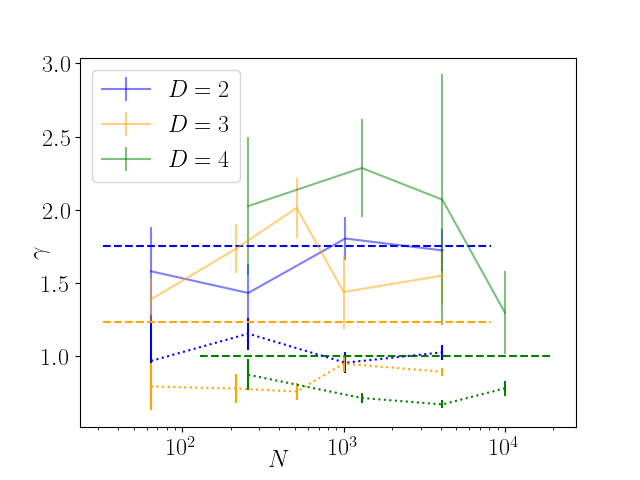

2 8 [1.58022511 0.96823489 0.25568423 0.07687027 0.02338219] 1.0589458452084846
2 16 [1.43223087 1.15452417 0.22787448 0.0425055  0.051286  ] 1.133590860681192
2 32 [1.80399533 0.95612274 0.22357506 0.03031694 0.07046423] 1.4647939104015937
2 64 [1.72256693 1.02731445 0.22007472 0.01465598 0.0817921 ] 2.353005438975732
3 4 [1.38864674 0.79380336 0.14582971 0.13895232 0.03404349] 1.398152552943818
3 6 [1.73568438 0.77955136 0.12550184 0.09021867 0.07454577] 1.0095134117741897
3 8 [2.01298204 0.75958413 0.11723648 0.0538303  0.11324751] 1.1980155492532512
3 10 [1.4389173  0.94976869 0.11328725 0.02419235 0.15210574] 1.181016122790413
3 16 [1.55102119 0.89480505 0.11169933 0.01190516 0.16396732] 2.1836477069763824
4 4 [2.02533733 0.87416846 0.08333716 0.05741183 0.11561313] 0.9634423935763272
4 6 [2.28543142 0.71526352 0.07811214 0.01907786 0.14254831] 1.4416335945901997
4 8 [2.06931441 0.67171623 0.07615956 0.00729614 0.17258821] 1.8049199888006044
4 10 [1.29801582 0.7813836  0.07483604 

In [67]:
## mass estimation of gamma as d|m|/dT
gamma_ths = [0,0,1.75,1.237,1.]
Ds = [2,3,4]
colors = ['blue','orange','green']
Ns = [[],
      [],
      [8,16,32,64],
      [4,6,8,10,16],
      [4,6,8,10]]
suffix = ''
k_min = 0
k_maxs = [[],
          [],
          [0.4,0.35,0.3,0.28],
          [0.25,0.19,0.17,0.16,0.155],
          [0.13,0.11,0.095,0.09]]
k_c_0s = [[],
          [],
          [0.254,0.229,0.224,0.221],
          [0.145,0.125,0.117,0.115,0.113],
          [0.083,0.078,0.076,0.075]]
delta_k = 0.

df_suffix = '_a'
n = 3

fig,ax = plt.subplots()
for j,D in enumerate(Ds):
    gamma_1s = []
    gamma_2s = []
    k_cs = []
    for i,N in enumerate(Ns[D]):
        try:
            df = load(D,N,suffix,df_suffix=df_suffix)
        except ValueError:
            continue

        k_max = k_maxs[D][i]
        k_c_0 = k_c_0s[D][i]
        k_u, k_l = k_c_0 - delta_k, k_c_0 + delta_k
        
        ks = np.array([k for k in df['k'] if k >= k_min and k < k_u])
        ts = smoothen(1/ks, n)
        ks = 1/ts[:-1]
        as_n = np.array([a for i,a in enumerate(df['abs_m']) if df['k'][i] >= k_min and df['k'][i] < k_u])
        as_s = np.array([a for i,a in enumerate(df['abs_m_std']) if df['k'][i] >= k_min and df['k'][i] < k_u])
        aas = smoothen(np.array([unc.ufloat(as_n[i],as_s[i]) for i in range(len(as_n))]), n)
        c_Bs = -np.diff(aas,1)/np.diff(ts,1)

        ks_2 = np.array([k for k in df['k'] if k >= k_l and k < k_max])
        ts = smoothen(1/ks_2, n)
        ks_2 = 1/ts[:-1]
        as_n = np.array([a for i,a in enumerate(df['abs_m']) if df['k'][i] >= k_l and df['k'][i] < k_max])
        as_s = np.array([a for i,a in enumerate(df['abs_m_std']) if df['k'][i] >= k_l and df['k'][i] < k_max])
        aas = smoothen(np.array([unc.ufloat(as_n[i],as_s[i]) for i in range(len(as_n))]), n)
        c_Bs_2 = -np.diff(aas,1)/np.diff(ts,1)

        ks = np.concatenate([ks,ks_2])
        c_Bs = np.concatenate([c_Bs,c_Bs_2])
        
        popt,pcov = op.curve_fit(alpha_exponent3, ks, [c_B.n for c_B in c_Bs],
                             sigma=[c_B.s for c_B in c_Bs], absolute_sigma=True,
                             p0=[1,1,k_c_0,0.1,0.1])
        gamma_1,gamma_2,k_c,A_1,A_2 = unc.correlated_values(popt,pcov)

        print(D,N,popt,r_chi2(alpha_exponent3,popt,ks,[c_B.n for c_B in c_Bs],sigy=[c_B.s for c_B in c_Bs]))
        gamma_1s.append(gamma_1)
        gamma_2s.append(gamma_2)
        k_cs.append(k_c)
        
#         submit('critical_exponents.csv',D,N,'gamma_1_d',gamma_1)
#         submit('critical_exponents.csv',D,N,'gamma_2_d',gamma_2)
#         submit('critical_exponents.csv',D,N,'k_c',k_c,note='from gamma_d')

    plt.semilogx([0.5*Ns[D][0]**D,2*Ns[D][-1]**D], [gamma_ths[D],gamma_ths[D]],
                 linestyle='dashed',color=colors[j])
    plt.errorbar(np.array(Ns[D])**D,[a.n for a in gamma_1s],yerr=[a.s for a in gamma_1s],
                 label='$D=%d$' %D,color=colors[j],alpha=0.5)
    plt.errorbar(np.array(Ns[D])**D,[a.n for a in gamma_2s],yerr=[a.s for a in gamma_2s],
                 linestyle='dotted',color=colors[j])
    
plt.legend(loc='upper left')
plt.xlabel('$N$')
plt.ylabel(r'$\gamma$')

ax.xaxis.set_label_coords(0.4,-0.06)
ax.yaxis.set_label_coords(-0.06,0.47)

# fig.savefig('report/img/gammas_d.pgf')

[0.09365411 0.22103907 0.96598278]


<IPython.core.display.Javascript object>


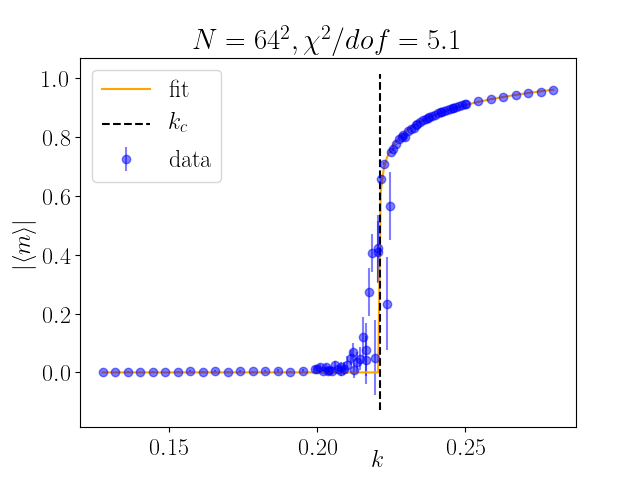

0.0937+/-0.0005
0.22104+/-0.00007


In [96]:
## trying estimate beta
%matplotlib notebook
D = 2
N = 64
suffix = ''

k_min, k_max = 0.0, 0.28
k_c_0 = 0.07

df = load(D=D,N=N,suffix=suffix)

ks = np.array([k for k in df['k'] if k >= k_min and k < k_max])
ms = np.array([np.abs(m) for i,m in enumerate(df['m']) if df['k'][i] >= k_min and df['k'][i] < k_max])
sig_ms = np.array([sm for i,sm in enumerate(df['m_std']) if df['k'][i] >= k_min and df['k'][i] < k_max])
# print(len(ks))

popt,pcov = op.curve_fit(beta_exponent, ks, ms, sigma=sig_ms, absolute_sigma=True, p0=[1.,k_c_0,1.])
print(popt)

beta,k_c,A = unc.correlated_values(popt,pcov)

fig,ax = plt.subplots()
plt.errorbar(ks,ms,yerr=sig_ms,fmt='o',label='data',color='blue',alpha=0.5)
plt.plot(ks,beta_exponent(ks,*popt),label='fit',color='orange')
plt.plot([k_c.n,k_c.n],ax.get_ylim(),color='black',linestyle='dashed',label='$k_c$')

plt.xlabel('$k$')
plt.ylabel(r'$|\langle m \rangle|$')
plt.title('$N = %d^%d, \chi^2/dof = %.1f$' %(N,D,r_chi2(beta_exponent,popt,ks,ms,sigy=sig_ms)))
plt.legend()

ax.xaxis.set_label_coords(0.6,-0.06)
# fig.savefig('report/img/D2_N64_beta.pgf')
print(beta)
print(k_c)

In [ ]:
submit('critical_exponents.csv',D,N,'beta',beta)
submit('critical_exponents.csv',D,N,'k_c',k_c,note='from beta')

<IPython.core.display.Javascript object>


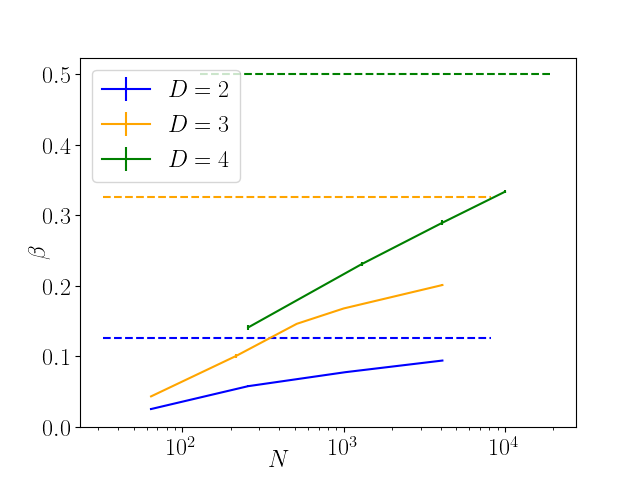

2 8 [0.02481085 0.25437688 0.98805961] 1.6801821800072239
2 16 [0.05728327 0.22929267 0.96967439] 3.443945045150776
2 32 [0.07713259 0.22448147 0.96717188] 2.0156183636869796
2 64 [0.09365464 0.22103896 0.96598268] 5.051221909040572
3 4 [0.0427982  0.14413257 0.95137574] 2.7479452960453634
3 6 [0.10033403 0.12467118 0.88054289] 2.1451462390189415
3 8 [0.14579572 0.11724138 0.82697529] 2.513223060720438
3 10 [0.16762172 0.11531571 0.80661626] 2.4457341258402785
3 16 [0.20089474 0.11282211 0.77557841] 7.341840612936321
4 4 [0.14067266 0.08425734 0.78657757] 2.5208759731863077
4 6 [0.23066673 0.07781529 0.67168245] 4.4417397893445205
4 8 [0.28938394 0.07617512 0.62200733] 2.6525599979187238
4 10 [0.33333449 0.07538334 0.59451321] 2.068460870935281


In [87]:
## mass estimation of beta
beta_ths = [0,0,0.125,0.3264,0.5]
Ds = [2,3,4]
colors = ['blue','orange','green']
Ns = [[],
      [],
      [8,16,32,64],
      [4,6,8,10,16],
      [4,6,8,10]]
suffix = ''
k_min = 0
k_maxs = [[],
          [],
          [0.4,0.35,0.3,0.28],
          [0.25,0.19,0.17,0.16,0.155],
          [0.13,0.11,0.095,0.09]]

fig,ax = plt.subplots()
for j,D in enumerate(Ds):
    betas = []
    k_cs = []
    for i,N in enumerate(Ns[D]):
        try:
            df = load(D,N,suffix)
        except ValueError:
            continue

        k_max = k_maxs[D][i]
        ks = np.array([k for k in df['k'] if k >= k_min and k < k_max])
        ms = np.array([np.abs(m) for i,m in enumerate(df['m']) if df['k'][i] >= k_min and df['k'][i] < k_max])
        sig_ms = np.array([sm for i,sm in enumerate(df['m_std']) if df['k'][i] >= k_min and df['k'][i] < k_max])

        popt,pcov = op.curve_fit(beta_exponent, ks, ms, sigma=sig_ms, absolute_sigma=False, p0=[1.,k_c_0,1.])
        print(D,N,popt,r_chi2(beta_exponent,popt,ks,ms,sigy=sig_ms))
#         ax.plot(ks,beta_exponent(ks,*popt),color=colors[j])
        beta,k_c,A = unc.correlated_values(popt,pcov)
        betas.append(beta)
        k_cs.append(k_c)
        
#         submit('critical_exponents.csv',D,N,'beta',beta)
#         submit('critical_exponents.csv',D,N,'k_c',k_c,note='from beta')

    plt.semilogx([0.5*Ns[D][0]**D,2*Ns[D][-1]**D], [beta_ths[D],beta_ths[D]],
                 linestyle='dashed',color=colors[j])
    plt.errorbar(np.array(Ns[D])**D,[b.n for b in betas],yerr=[b.s for b in betas],
                 label='$D=%d$' %D,color=colors[j])
    
plt.legend(loc='upper left')
plt.xlabel('$N$')
plt.ylabel(r'$\beta$')

ax.xaxis.set_label_coords(0.4,-0.06)
ax.yaxis.set_label_coords(-0.06,0.47)

# fig.savefig('report/img/betas.pgf')

50
0.22103899999999999 [16.76664883  1.03418313]


<IPython.core.display.Javascript object>


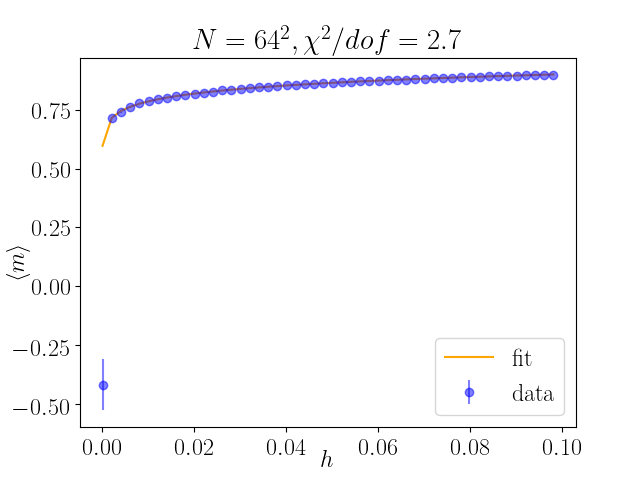

In [108]:
## trying to estimate delta
%matplotlib notebook
D = 2
N = 64
suffix = '_delta'

h_min, h_max = 0.0, 0.1

df = load(D=D,N=N,suffix=suffix)

hs = np.array([h for h in df['h'] if h >= h_min and h < h_max])
ms = np.array([m for i,m in enumerate(df['m']) if df['h'][i] >= h_min and df['h'][i] < h_max])
sig_ms = np.array([sm for i,sm in enumerate(df['m_std']) if df['h'][i] >= h_min and df['h'][i] < h_max])
print(len(hs))

popt,pcov = op.curve_fit(delta_exponent, hs, ms, sigma=sig_ms, absolute_sigma=True, p0=[15.,1.])
print(df['k'][0],popt)

fig,ax = plt.subplots()
plt.errorbar(hs,ms,yerr=sig_ms,fmt='o',label='data',color='blue',alpha=0.5)
plt.plot(hs,delta_exponent(hs,*popt),label='fit',color='orange')
plt.xlabel('$h$')
plt.ylabel(r'$\langle m \rangle$')
plt.title(r'$N = %d^%d, \chi^2/dof = %.1f$' %(N,D,r_chi2(delta_exponent,popt,hs,ms,sig_ms)))
plt.legend()



ax.xaxis.set_label_coords(0.5,-0.06)
ax.yaxis.set_label_coords(-0.1,0.45)
# fig.savefig('report/img/D2_N64_delta.pgf')

<IPython.core.display.Javascript object>


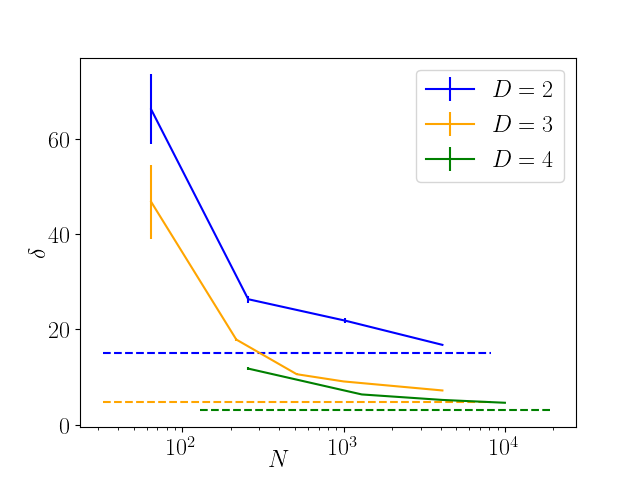

2 8 [66.24002264  0.98564643] 3.0117951757371415
2 16 [26.35207165  1.00046782] 2.70647260099112
2 32 [21.84544352  1.00741044] 6.356718038480245
2 64 [16.76664883  1.03418313] 2.718774765882021
3 4 [46.82028863  0.96652052] 4.063039464187784
3 6 [17.88024583  0.96709991] 2.2398796230696973
3 8 [10.59914458  1.00276453] 2.6131855398956803
3 10 [9.08203305 1.02452844] 3.313470786123761
3 16 [7.18792579 1.07298796] 4.803229760884969
4 4 [11.78133712  0.97342493] 2.6749489434382467
4 6 [6.35110442 1.05927443] 1.870559204884526
4 8 [5.19813365 1.11839455] 3.5356125791730393
4 10 [4.60400923 1.17163338] 4.506728177825029


In [6]:
## mass estimation of delta
%matplotlib notebook
delta_ths = [0,0,15,4.7898,3]
Ds = [2,3,4]
colors = ['blue','orange','green']
Ns = [[],
      [],
      [8,16,32,64],
      [4,6,8,10,16],
      [4,6,8,10]]
suffix = '_delta'
h_min = 0
h_max = 0.1

fig,ax = plt.subplots()
for j,D in enumerate(Ds):
    deltas = []
    for i,N in enumerate(Ns[D]):
        try:
            df = load(D,N,suffix)
        except ValueError:
            continue

        hs = np.array([h for h in df['h'] if h >= h_min and h < h_max])
        ms = np.array([m for i,m in enumerate(df['m']) if df['h'][i] >= h_min and df['h'][i] < h_max])
        sig_ms = np.array([sm for i,sm in enumerate(df['m_std']) if df['h'][i] >= h_min and df['h'][i] < h_max])

        popt,pcov = op.curve_fit(delta_exponent, hs, ms, sigma=sig_ms, absolute_sigma=False, p0=[1.,1.])
        print(D,N,popt,r_chi2(delta_exponent,popt,hs,ms,sigy=sig_ms))
#         ax.plot(ks,beta_exponent(ks,*popt),color=colors[j])
        delta,A = unc.correlated_values(popt,pcov)
        deltas.append(delta)
        
#         submit('critical_exponents.csv',D,N,'delta',delta)


    plt.semilogx([0.5*Ns[D][0]**D,2*Ns[D][-1]**D], [delta_ths[D],delta_ths[D]],
                 linestyle='dashed',color=colors[j])
    plt.errorbar(np.array(Ns[D])**D,[b.n for b in deltas],yerr=[b.s for b in deltas],
                 label='$D=%d$' %D,color=colors[j])
    
plt.legend(loc='upper right')
plt.xlabel('$N$')
plt.ylabel(r'$\delta$')

ax.xaxis.set_label_coords(0.4,-0.06)
ax.yaxis.set_label_coords(-0.06,0.47)

# fig.savefig('report/img/deltas.pgf')

In [5]:
## submit also bulk critical exponents
Ds = [2,3,4]

alpha_ths = [0,0,0.,0.11,0.]
beta_ths = [0,0,0.125,0.3264,0.5]
gamma_ths = [0,0,1.75,1.237,1.]
delta_ths = [0,0,15,4.7898,3]

# for D in Ds:
#     submit('critical_exponents.csv',D,0,'alpha',unc.ufloat(alpha_ths[D],0))
#     submit('critical_exponents.csv',D,0,'beta',unc.ufloat(beta_ths[D],0))
#     submit('critical_exponents.csv',D,0,'gamma',unc.ufloat(gamma_ths[D],0))
#     submit('critical_exponents.csv',D,0,'delta',unc.ufloat(delta_ths[D],0))


<IPython.core.display.Javascript object>


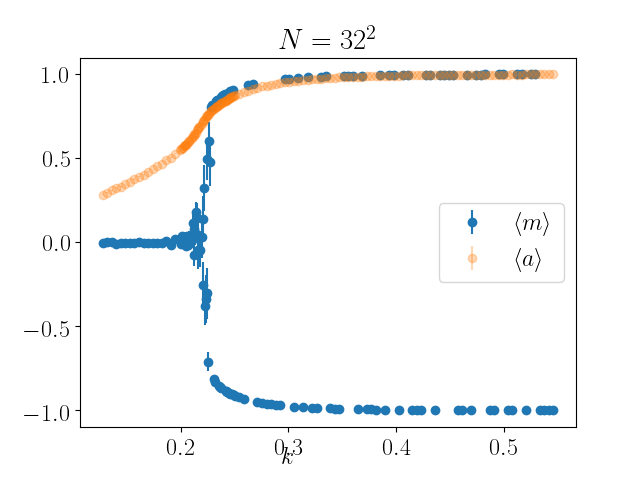

In [94]:
%matplotlib notebook
D = 2
N = 32
suffix = ''


df = load(D=D,N=N,suffix=suffix)

keys = ['m','a']
alphas = [1, 0.3]

fig, ax = plt.subplots()
for i,key in enumerate(keys):
    ax.errorbar(df['k'],df[key],yerr=df[key+'_std'],fmt='o',label=r'$\langle %s \rangle$' %key,alpha=alphas[i])

ax.set_title('$N = %d^%d$' %(N,D))
ax.set_xlabel('$k$')
# plt.ylabel('$a$')
ax.legend(loc='center right')
ax.xaxis.set_label_coords(0.42,-0.05)


# fig.savefig('report/img/D%d_N%d%s_am.pgf' %(D,N,suffix))

<IPython.core.display.Javascript object>


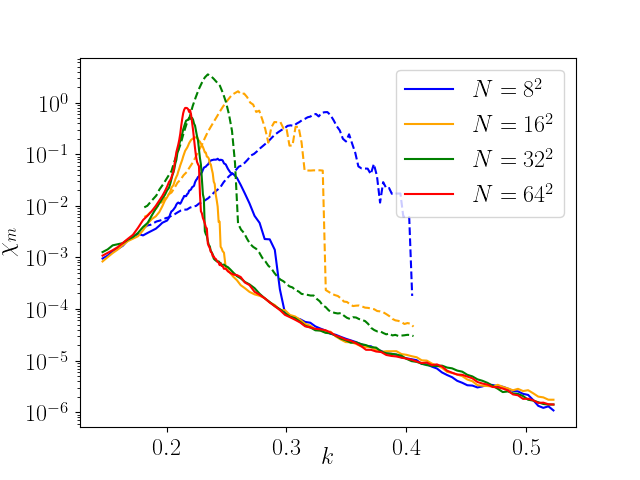

In [77]:
## chi peaks and alignment

D = 2
Ns = [8,16,32,64]
# Ns = [4,6,8,10,16]
# Ns = [4,6,8,10]
suffixs = ['','_free','_para'][:2]
n = 10
which_plot = 'chi'
df_suffix = '_a'

k_min = 0.15
k_maxs = [0.4,0.35,0.3,0.28]
k_c_0 = 0.25
k_cs = []
betas = []

colors = ['blue','orange', 'green', 'red','purple','brown']
linestyles = ['solid', 'dashed', 'dotted']

fig, ax = plt.subplots()
for i,N in enumerate(Ns):
    for j,suffix in enumerate(suffixs):
        try:
            df = load(D,N,suffix,df_suffix=df_suffix)
        except ValueError:
            continue
        if j == 0:
            if which_plot == 'chi':
                ax.semilogy(smoothen(df['k'],n),smoothen(df['abs_m_std'],n)**2*(N**D)*smoothen(df['k'],n),
                            label='$N = %d^%d$' %(N,D),color=colors[i],linestyle=linestyles[j])
            elif which_plot == 'm':
                k_max = k_maxs[i]
                ks = np.array([k for k in df['k'] if k >= k_min and k < k_max])
                ms = np.array([np.abs(m) for i,m in enumerate(df['m']) if df['k'][i] >= k_min and df['k'][i] < k_max])
                sig_ms = np.array([sm for i,sm in enumerate(df['m_std']) if df['k'][i] >= k_min and df['k'][i] < k_max])

                popt,pcov = op.curve_fit(beta_exponent, ks, ms, sigma=sig_ms, absolute_sigma=False, p0=[1.,k_c_0,1.])
                print(N,popt)
                ax.errorbar(ks,ms,yerr=sig_ms,fmt='o',alpha=0.5,
                            label='$N = %d^%d$' %(N,D),color=colors[i])
                ax.plot(ks,beta_exponent(ks,*popt),color=colors[i])
                beta,k_c,A = unc.correlated_values(popt,pcov)
                betas.append(beta)
                k_cs.append(k_c)
                
            else:
                ax.plot(df['k'],np.abs(df['a']),label='$N = %d^%d$' %(N,D),
                        color=colors[i],linestyle=linestyles[j])
        else:
            if which_plot == 'chi':
                ax.semilogy(smoothen(df['k'],n),smoothen(df['m_std'],n)**2*(N**D)*smoothen(df['k'],n),
                            color=colors[i],linestyle=linestyles[j])
            else:
                ax.plot(df['k'],np.abs(df['a']),label='',
                        color=colors[i],linestyle=linestyles[j])
#         ax.scatter(max_ks,max_chis,color='black')
        
if which_plot == 'chi':
    ax.set_ylabel('$\chi_m$')
else:
    ax.set_ylabel('$a$')
ax.set_xlabel('$k$')
ax.legend()

ax.xaxis.set_label_coords(0.5,-0.05)
# ax.set_xlim(0.09,0.28)
# fig.savefig('report/img/D2_chi_a.pgf')

if which_plot == 'm':
    print(betas,k_cs)

<IPython.core.display.Javascript object>


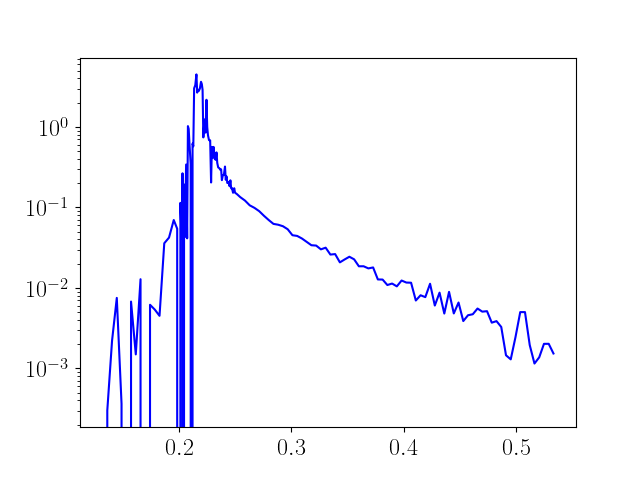

In [29]:
D = 2
Ns = [8,16,32,64][-1:]
suffixs = ['','_free','_para'][:1]
n = 3

colors = ['blue','orange', 'green', 'red','purple','brown']
linestyles = ['solid', 'dashed', 'dotted']

fig,ax = plt.subplots()
for i,N in enumerate(Ns):
    for j,suffix in enumerate(suffixs):
        try:
            df = load(D,N,suffix,df_suffix=df_suffix)
        except ValueError:
            continue
        ks = np.array(df['k'])
        ts = smoothen(1/ks, n)
        ks = 1/ts[:-1]
        as_n = np.array(df['abs_m'])
        as_s = np.array(df['abs_m_std'])
        aas = smoothen(np.array([unc.ufloat(as_n[i],as_s[i]) for i in range(len(as_n))]), n)
        chis = -np.diff(aas,1)/np.diff(ts,1)
        if j == 0:
            ax.semilogy(ks,[chi.n for chi in chis],
                        label='$N = %d^%d$' %(N,D),color=colors[i],linestyle=linestyles[j])
        else:
            ax.semilogy(ks,[chi.n for chi in chis],
                        color=colors[i],linestyle=linestyles[j])



In [58]:
n = 1
suffix = ''
max_ks = []
max_chis = []
k_FWHMs = []
for N in Ns:
    df = load(D,N,suffix)
    ks = smoothen(df['k'],n)
    chis = smoothen(df['m_std'],n)**2*(N**D)*ks
    k_max = ks[np.argmax(chis)]
    chi_max = np.max(chis)
    max_ks.append(k_max)
    max_chis.append(chi_max)
    k_m = 0
    k_M = 0
    found_m = False
    found_M = False
    for i,k in enumerate(ks):
        if not found_m and k <= k_max:
            if chis[i] > 0.5*chi_max:
                k_m = k
                found_m = True
        if not found_M and k >= k_max:
            if chis[i] < 0.5*chi_max:
                k_M = k
                found_M = True
    k_FWHM = k_M - k_m
    k_FWHMs.append(k_FWHM)
    k_c = unc.ufloat(k_max,0.5*k_FWHM)
    submit('critical_exponents.csv',D,N,'k_c',k_c,'from chi_a')
    print(N, chi_max, k_max, k_FWHM)

4 0.6837313121513336 0.0890909090909091 0.004949494949494954
6 1.7532238994244775 0.08026315789473701 0.0019218500797449911
8 2.4681206759716683 0.077222222222222 0.0007070707070710031
10 3.050322705928429 0.076076923076923 0.0003333333333340044


<IPython.core.display.Javascript object>


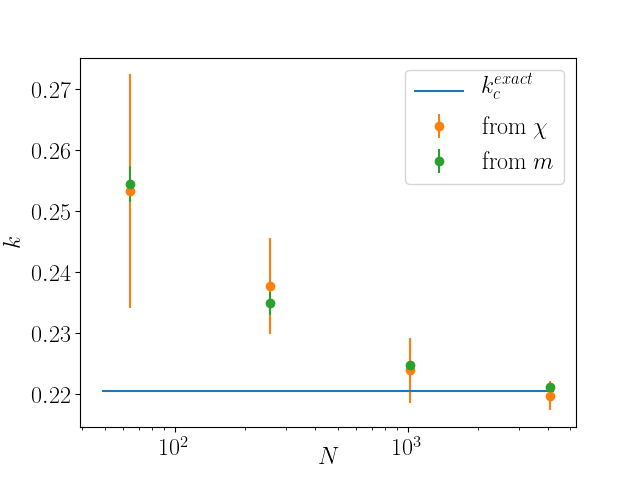

In [152]:
%matplotlib notebook
k_th = np.log(1 + np.sqrt(2))/4

fig,ax = plt.subplots()

ax.semilogx([7**2,65**2],[k_th,k_th],label='$k_c^{exact}$')
ax.errorbar(np.array(Ns)**D,max_ks,yerr=np.array(k_FWHMs)/2,fmt='o',label=r'from $\chi$')
ax.errorbar(np.array(Ns)**D,np.array([k.n for k in k_cs]),yerr=np.array([k.s for k in k_cs]),
                                     fmt='o',label=r'from $m$')

ax.set_xlabel('$N$')
ax.set_ylabel('$k$')
ax.legend()

ax.xaxis.set_label_coords(0.5,-0.05)

# fig.savefig('report/img/D2_kc.pgf')

<IPython.core.display.Javascript object>


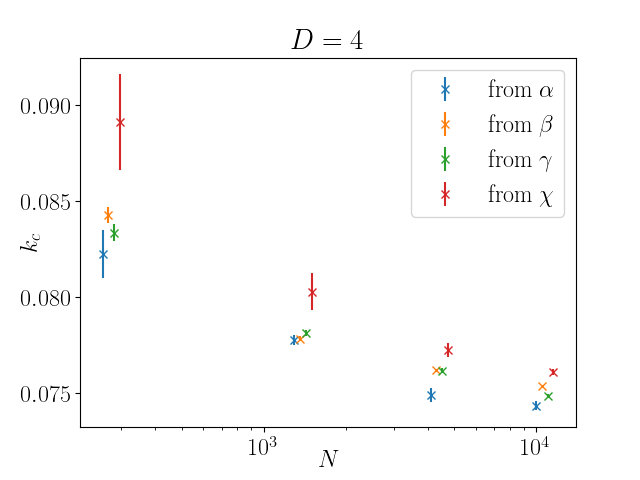

In [106]:
%matplotlib notebook

# compare different estimates of the critical point

df = pd.read_csv('critical_exponents.csv')

D = 4
notes = ['from alpha', 'from beta', 'from gamma_d','from chi_a']
labels = [r'from $\alpha$',r'from $\beta$',r'from $\gamma$',r'from $\chi$']

fig, ax = plt.subplots()
for j,note in enumerate(notes):
    Ns = []
    k_cs = []
    k_c_sigs = []
    for i in range(len(df)):
        if df['D'][i] == D and df['notes'][i] == note:
            Ns.append(df['N'][i]**D*1.05**j)
            k_cs.append(df['exp_value'][i])
            k_c_sigs.append(df['exp_std'][i])
    
    ax.errorbar(Ns,k_cs,yerr=k_c_sigs,fmt='x',label=labels[j])

if D == 2:
    k_th = np.log(1 + np.sqrt(2))/4
    ax.plot(ax.get_xlim(),[k_th,k_th],label='exact')
ax.semilogx([],[])
    
plt.xlabel('$N$')
plt.ylabel('$k_c$')
plt.title('$D = %d$' %D)
ax.legend()
plt.locator_params(axis='y',nbins=5)

ax.xaxis.set_label_coords(0.5,-0.06)
ax.yaxis.set_label_coords(-0.07,0.5)
# fig.savefig('report/img/D%d_k_c.pgf' %D)

In [36]:
## make a table for latex
def nice_error(v,s):
    digits = -int(np.log10(s)) + 1
    if s*10**digits >= 9.5:
        digits -= 1
    if digits < 0:
        digits = 0
    return ('$%.' + str(digits) + 'f \\pm %.' + str(digits) + 'f$') %(round(v,digits),round(s,digits))

Ds = [2,3,4]
Ns = [[],
      [],
      [8,16,32,64],
      [4,6,8,10,16],
      [4,6,8,10]]

exp_names = ['alpha_1','alpha_2','beta','gamma_1_d','gamma_2_d','delta']
exp_values = np.zeros(len(exp_names))
exp_stds = np.zeros(len(exp_names))

exp_names_th = ['alpha','beta','gamma','delta']
exp_values_th = np.zeros(len(exp_names_th))

df = pd.read_csv('critical_exponents.csv')

print('\\toprule')
print('$N$ & $\\alpha_1$ & $\\alpha_2$ & $\\beta$ & $\\gamma_1$ & $\\gamma_2$ & $\\delta$ \\\\')

for D in Ds:
    print('\midrule')
    for N in Ns[D]:
        line = '$%d^%d$' %(N,D)
        exp_values = np.zeros(len(exp_names))
        exp_stds = np.zeros(len(exp_names))
        for i in range(len(df)):
            if df['D'][i] == D and df['N'][i] == N:
                for j,name in enumerate(exp_names):
                    if df['exp_name'][i] == name:
                        exp_values[j] = df['exp_value'][i]
                        exp_stds[j] = df['exp_std'][i]

        for j,v in enumerate(exp_values):
            s = exp_stds[j]
            line += ' & ' + nice_error(v,s)
        line += '\\\\'
        print(line)
    
    line = '$\\infty^%d$' %D
    exp_values_th = np.zeros(len(exp_names_th))
    for i in range(len(df)):
        if df['D'][i] == D and df['N'][i] == 0:
            for j,name in enumerate(exp_names_th):
                if df['exp_name'][i] == name:
                    exp_values_th[j] = df['exp_value'][i]

    line += ' & \\multicolumn{2}{c}{$%.3f$} & $%.3f$ & \\multicolumn{2}{c}{$%.3f$} & $%.3f$' %tuple(exp_values_th)
    line += '\\\\'
    print(line)
print('\\bottomrule')

\toprule
$N$ & $\alpha_1$ & $\alpha_2$ & $\beta$ & $\gamma_1$ & $\gamma_2$ & $\delta$ \\
\midrule
$8^2$ & $0.56 \pm 0.05$ & $0.4 \pm 0.1$ & $0.025 \pm 0.002$ & $1.6 \pm 0.3$ & $1.0 \pm 0.3$ & $66 \pm 7$\\
$16^2$ & $0.62 \pm 0.03$ & $0.48 \pm 0.06$ & $0.057 \pm 0.001$ & $1.4 \pm 0.2$ & $1.2 \pm 0.1$ & $26.4 \pm 0.7$\\
$32^2$ & $0.69 \pm 0.02$ & $0.39 \pm 0.04$ & $0.0771 \pm 0.0006$ & $1.8 \pm 0.1$ & $0.96 \pm 0.07$ & $21.8 \pm 0.5$\\
$64^2$ & $0.697 \pm 0.009$ & $0.37 \pm 0.02$ & $0.094 \pm 0.001$ & $1.7 \pm 0.1$ & $1.03 \pm 0.05$ & $16.8 \pm 0.1$\\
$\infty^2$ & \multicolumn{2}{c}{$0.000$} & $0.125$ & \multicolumn{2}{c}{$1.750$} & $15.000$\\
\midrule
$4^3$ & $0.48 \pm 0.04$ & $0.4 \pm 0.1$ & $0.0428 \pm 0.0008$ & $1.4 \pm 0.1$ & $0.8 \pm 0.2$ & $47 \pm 8$\\
$6^3$ & $0.80 \pm 0.04$ & $0.29 \pm 0.06$ & $0.100 \pm 0.003$ & $1.7 \pm 0.2$ & $0.8 \pm 0.1$ & $17.9 \pm 0.4$\\
$8^3$ & $1.02 \pm 0.05$ & $0.34 \pm 0.04$ & $0.1458 \pm 0.0009$ & $2.0 \pm 0.2$ & $0.76 \pm 0.06$ & $10.6 \pm 0.2$\\
$10

In [28]:
nice_error(0.559,0.0535)

'$0.56 \\pm 0.05$'

In [23]:
df

,D,N,exp_name,exp_value,exp_std,notes
0,2,8,alpha_1,0.559738,0.053506,NaN
1,2,8,alpha_2,0.428797,0.133314,NaN
2,2,8,k_c,0.256889,0.001926,from alpha
3,2,16,alpha_1,0.618245,0.033040,NaN
4,2,16,alpha_2,0.483444,0.063575,NaN
5,2,16,k_c,0.228703,0.000672,from alpha
6,2,32,alpha_1,0.687273,0.017726,NaN
7,2,32,alpha_2,0.387258,0.038563,NaN
8,2,32,k_c,0.224310,0.000357,from alpha
9,2,64,alpha_1,0.697119,0.009341,NaN


<IPython.core.display.Javascript object>


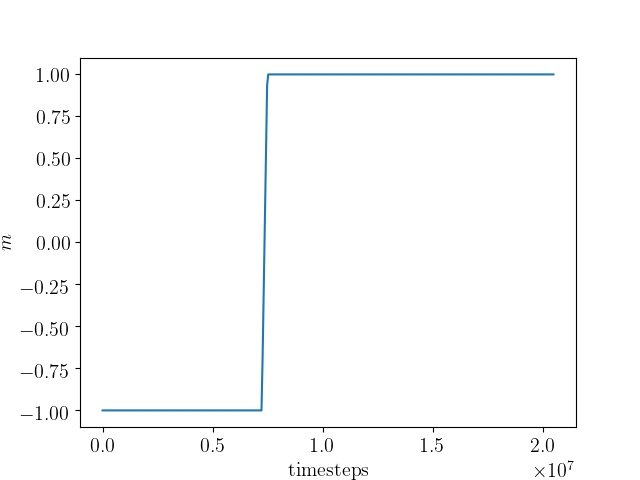

In [59]:
e_df = pd.read_csv('sim/D1_N1024/evolution_k2.3018.csv')
plt.figure()
plt.plot(e_df['step'],e_df['m'])
plt.xlabel('timesteps')
plt.ylabel('$m$')

plt.savefig('report/img/D1_N1024_k2.3_instanton.pgf')